In [1]:
%run ../_config/config.py # Import the configuration settings
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

In [2]:
moma_sample = pd.read_csv("../data/moma_sample.csv")

In [3]:
moma_sample.head()

,artist,country,birth,death,alive,genx,gender,count,year_acquired_min,year_acquired_max
0,Ad Gerritsen,dutch,1940,2015.0,False,False,male,1,1981,1981
1,Kirstine Roepstorff,danish,1972,NaN,True,True,female,3,2005,2005
2,Lisa Baumgardner,american,1958,2015.0,False,False,female,2,2016,2016
3,David Bates,american,1952,NaN,True,False,male,1,2001,2001
4,Simon Levy,american,1946,NaN,True,False,male,1,2012,2012


In [4]:
result = moma_sample["genx"].value_counts()
print(result)

genx
False    86
True     14
Name: count, dtype: int64


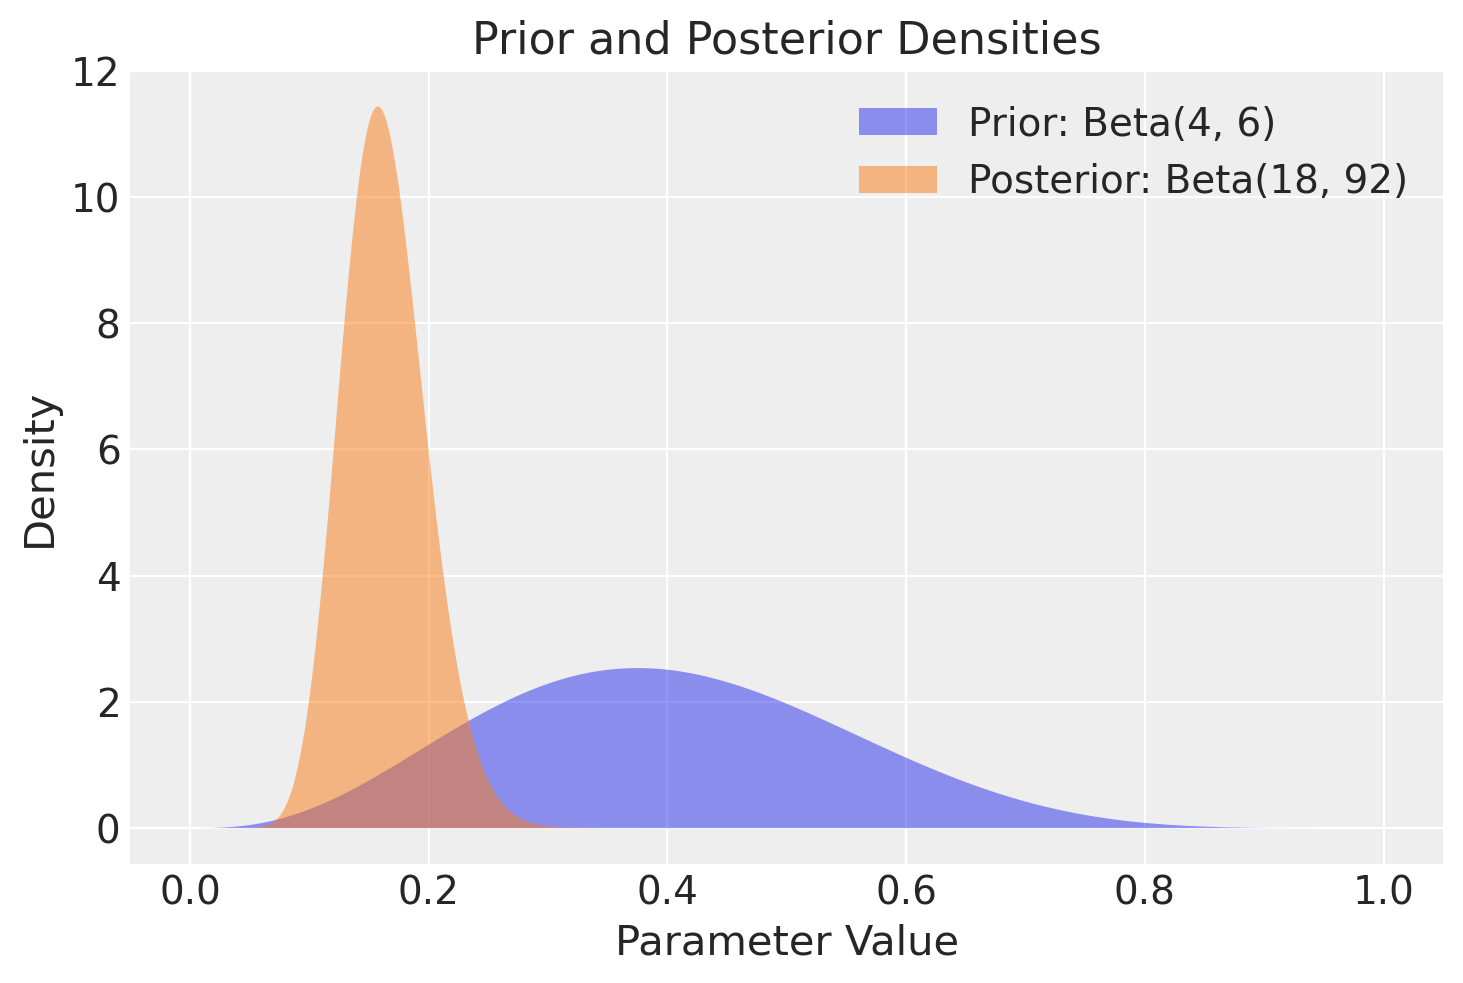

In [5]:
x = np.linspace(0, 1, 1000)

prior_density = stats.beta.pdf(x, 4, 6)
posterior_density = stats.beta.pdf(x, 18, 92)

plt.fill_between(x, prior_density, alpha=0.5, label="Prior: Beta(4, 6)")
plt.fill_between(x, posterior_density, alpha=0.5, label="Posterior: Beta(18, 92)")
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.legend()
plt.title("Prior and Posterior Densities")
plt.show()

In [6]:
y = stats.beta(18, 92).rvs(10)
print(y)

[0.15055982 0.11082285 0.12981996 0.14002846 0.17033033 0.1016842
 0.16416764 0.10067355 0.21453883 0.14023775]


In [7]:
np.mean(y)

0.14228633744567315

In [8]:
stats.beta(18, 92).rvs(10000).mean()

0.1633850963306632

In [9]:
def simulate_markov_visits(island_sizes, n_steps=100_000):
    """aka Metropolis algorithm"""

    # Metropolis algorithm
    island_idx = np.arange(len(island_sizes))
    visits = {ii: 0 for ii in island_idx}
    current_island_idx = np.random.choice(island_idx)
    markov_chain = []  # store history
    for _ in range(n_steps):
        # 1. Flip a coin to propose a direction, left or right
        coin_flip = np.random.rand() > 0.5
        direction = -1 if coin_flip else 1
        proposal_island_idx = np.roll(island_idx, direction)[current_island_idx]

        # 2. Proposal island size
        proposal_size = island_sizes[proposal_island_idx]

        # 3. Current island size
        current_size = island_sizes[current_island_idx]

        # 4. Go to proposal island if ratio of sizes is greater than another coin flip
        p_star = proposal_size / current_size
        move = np.random.rand() < p_star
        current_island_idx = proposal_island_idx if move else current_island_idx

        # 5. tally visits and repeat
        visits[current_island_idx] += 1
        markov_chain.append(current_island_idx)

    # Visualization
    island_idx = visits.keys()
    island_visit_density = [v / n_steps for v in visits.values()]
    island_size_density = island_sizes / island_sizes.sum()

    _, axs = plt.subplots(1, 2, figsize=(12, 4))

    plt.sca(axs[0])
    plt.plot(island_sizes, lw=3, color='C0')
    plt.xlabel("Island Index")
    plt.ylabel("Island Population");
    plt.xticks(np.arange(len(island_sizes)));

    plt.sca(axs[1])
    plt.plot(island_idx, island_size_density, color='C0', lw=3, label='Population')
    plt.bar(island_idx, island_visit_density, color='k', width=.4, alpha=0.5, label='Visits')

    plt.xlabel("Island Index")
    plt.ylabel("Density");
    plt.xticks(np.arange(len(island_sizes)));

    plt.legend()
    return markov_chain

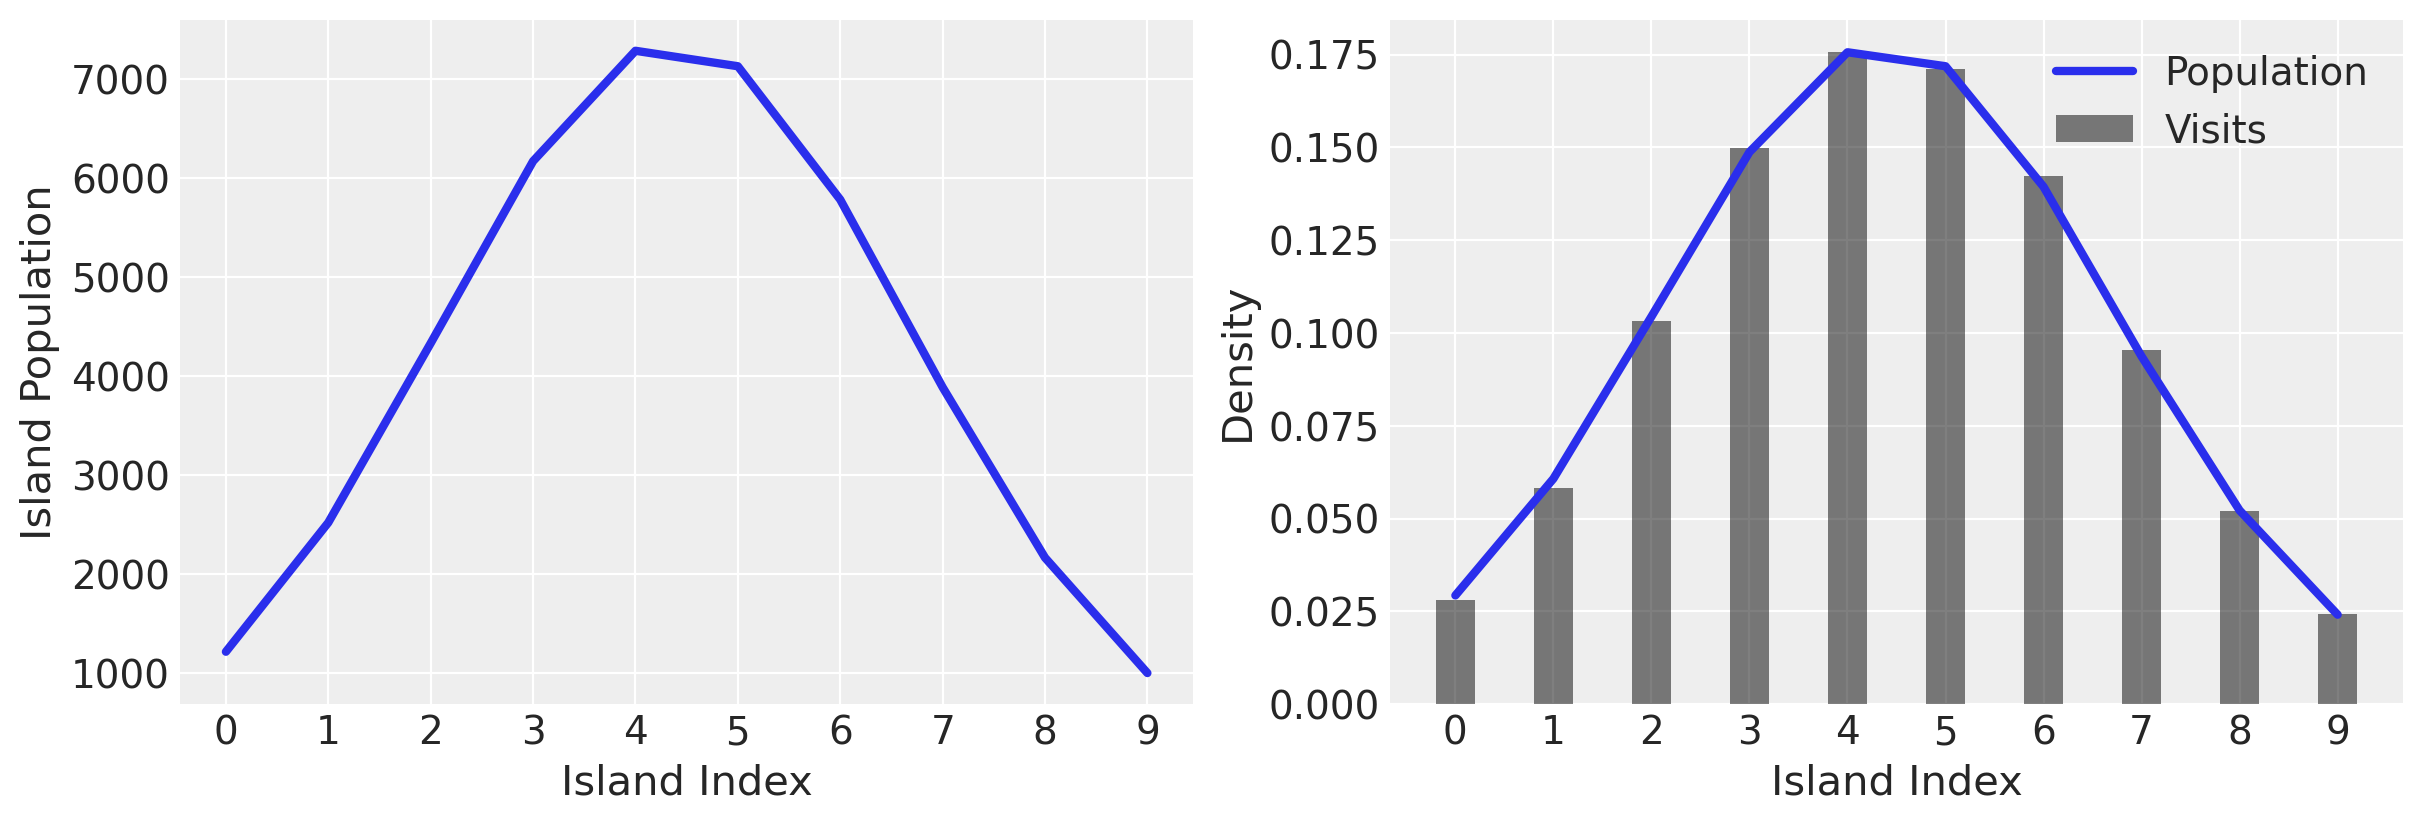

In [10]:
n_steps = 100_000
island_sizes = stats.norm(20, 10).pdf(np.linspace(1, 40, 10))
island_sizes /= island_sizes.min() / 1000

gaussian_markov_chain = simulate_markov_visits(island_sizes, n_steps)

In [11]:
def plot_markov_chain(markov_chain, **hist_kwargs):
    _, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    plt.sca(axs[0])
    plt.plot(markov_chain[:500])
    plt.xlabel("visit number")
    plt.ylabel("island index")
    plt.title("Metropolis Algorithm Markov Chain\nFirst 500 Steps");

    plt.sca(axs[1])
    plt.hist(markov_chain, orientation='horizontal', alpha=0.5, density=True, **hist_kwargs);
    plt.title("Resulting Posterior\n(horizontal)");

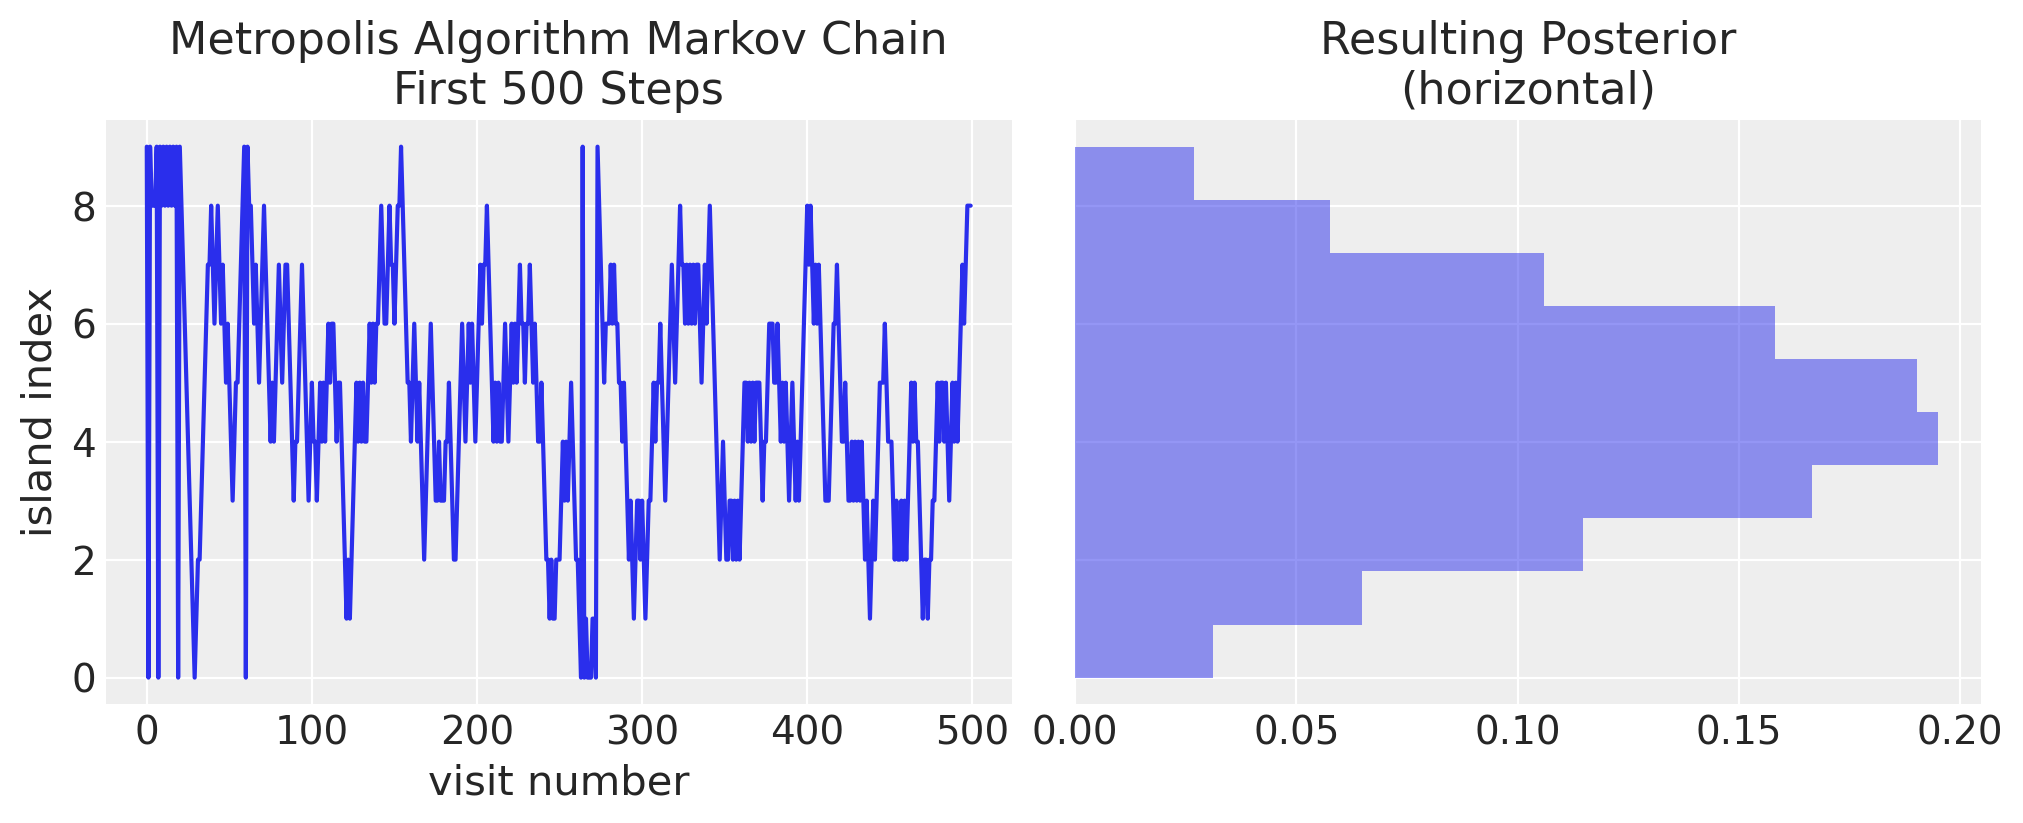

In [12]:
plot_markov_chain(gaussian_markov_chain, bins=10)

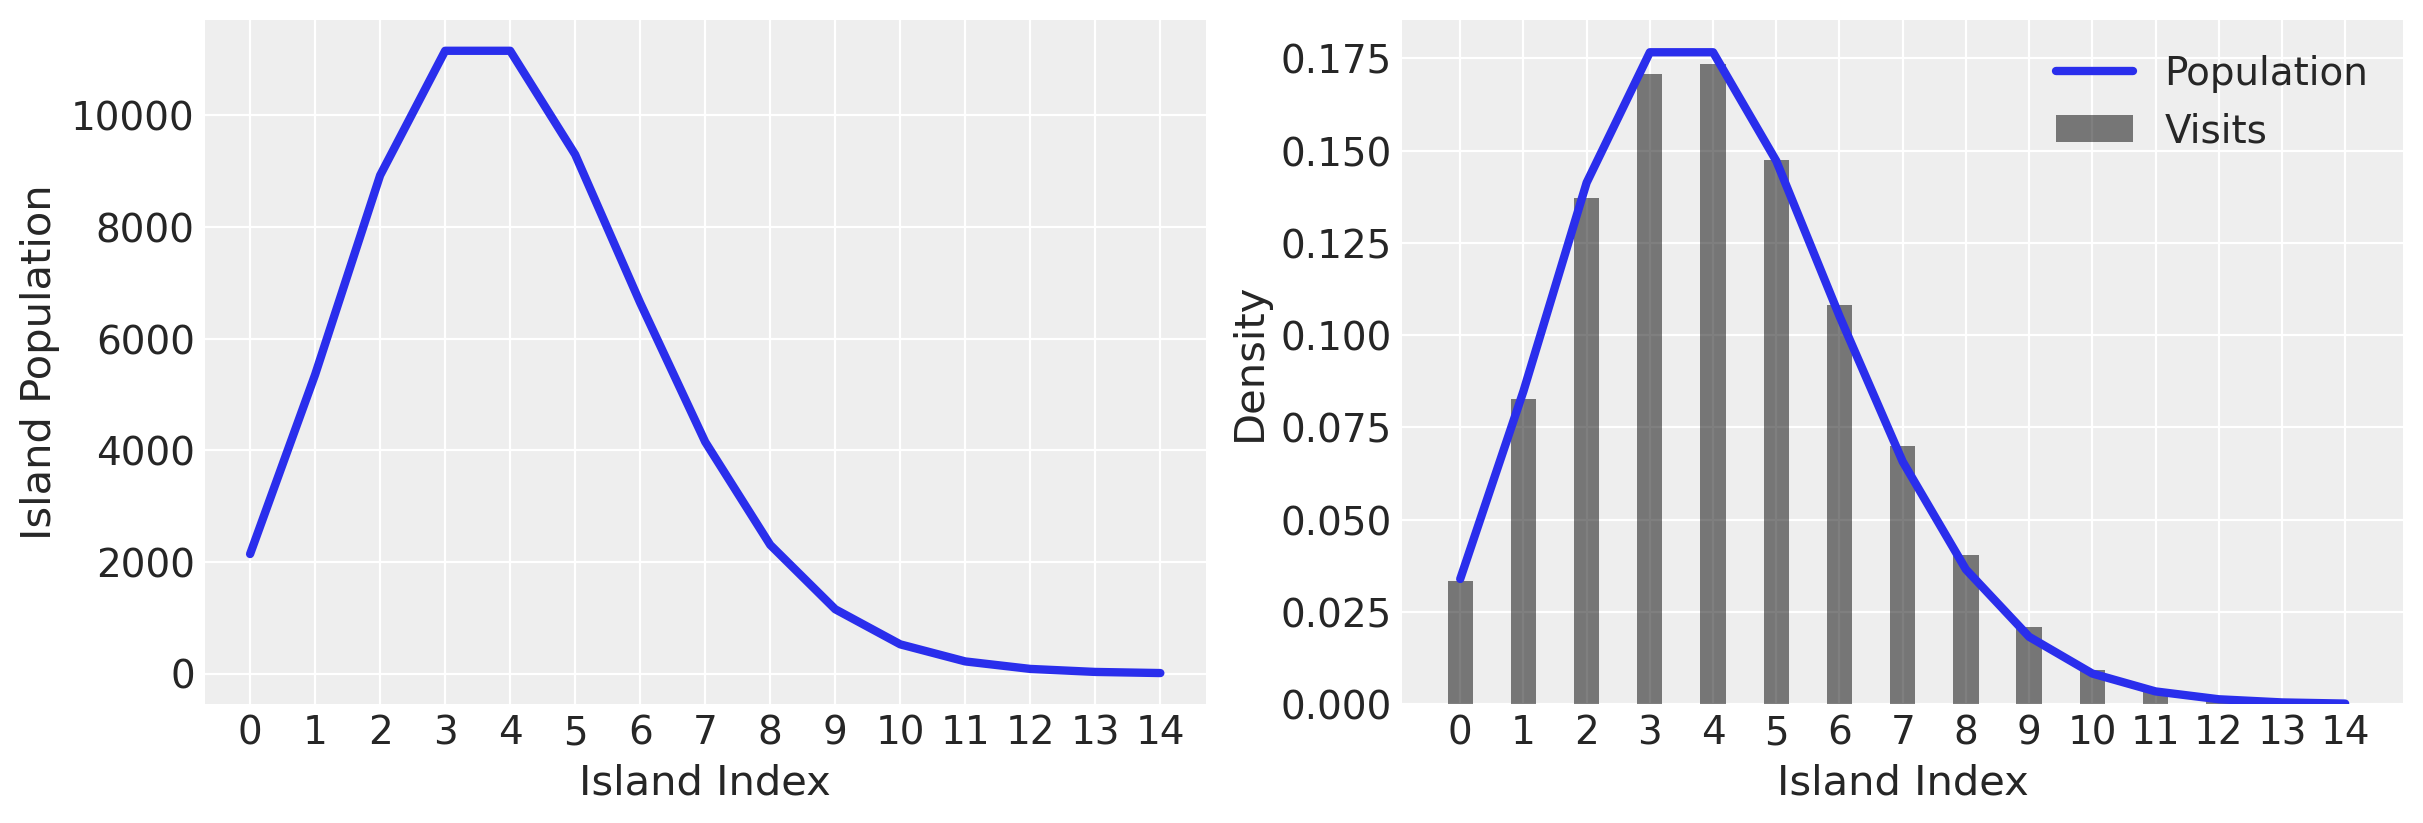

In [13]:
island_sizes = stats.poisson(5).pmf(np.linspace(1, 15, 15))
island_sizes /= island_sizes.min() / 10

poisson_markov_chain = simulate_markov_visits(island_sizes, n_steps);

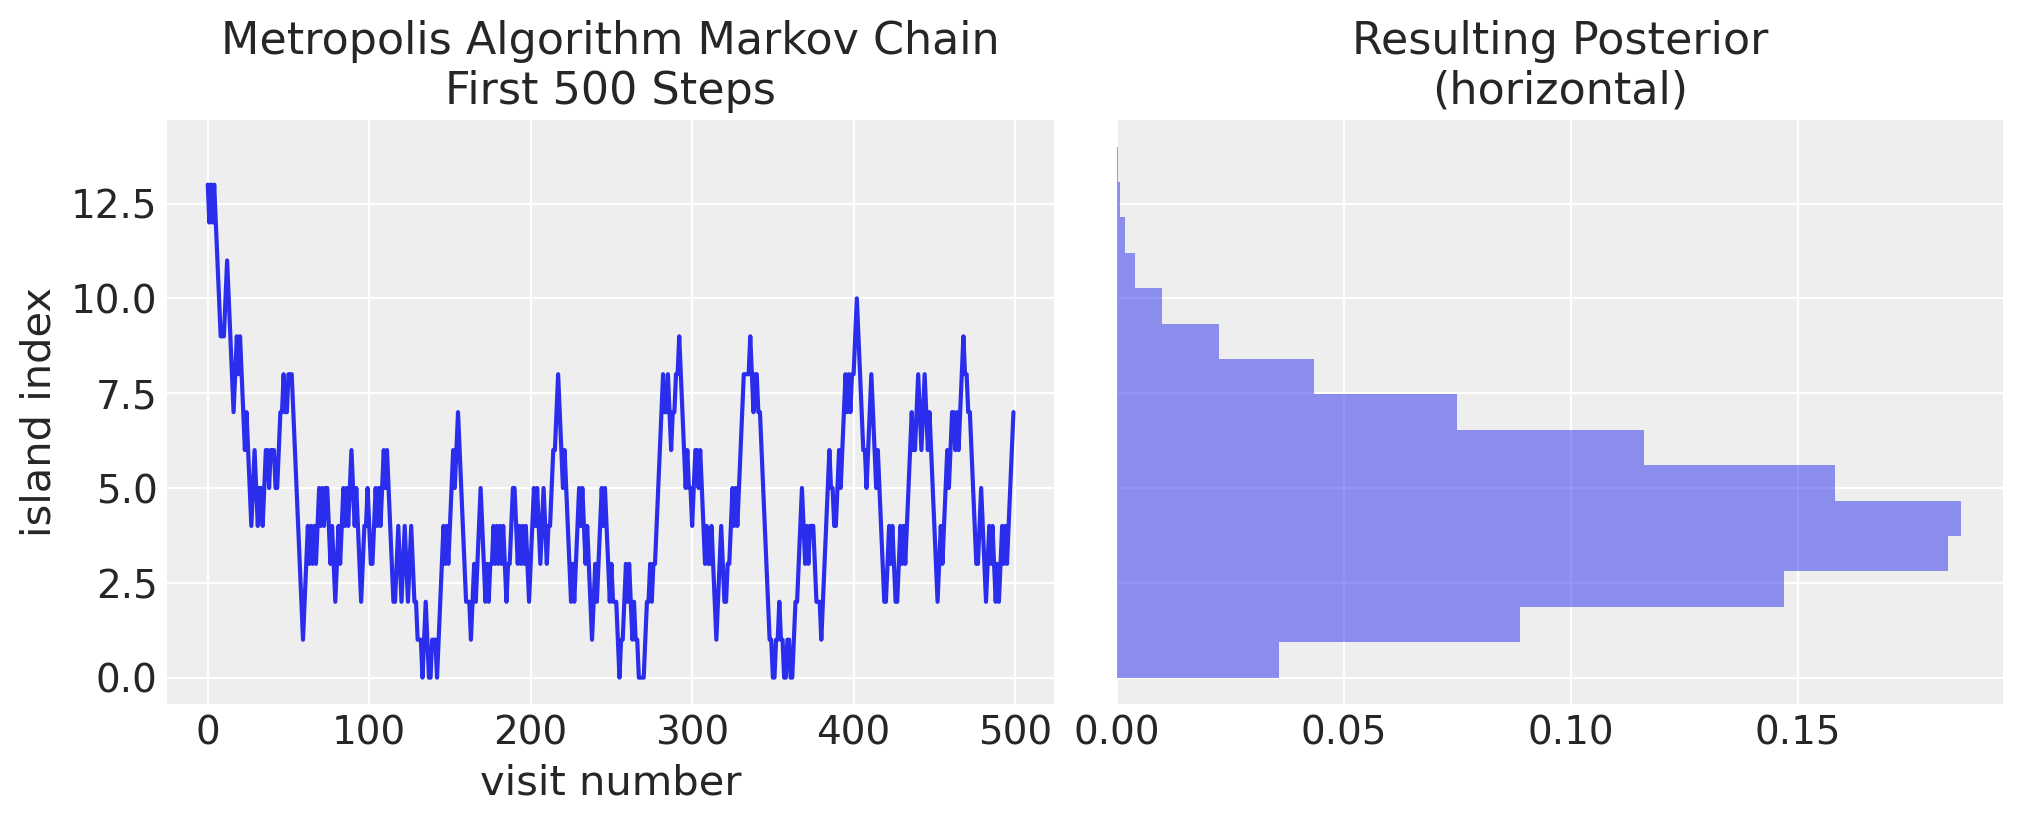

In [14]:
plot_markov_chain(poisson_markov_chain, bins=15)

In [15]:
# Proposal distribution
def uniprop(xprev, delta=0.05):
    return xprev + stats.uniform.rvs(loc=-delta, scale=2 * delta)

In [16]:
# Metropolis algorithm 
def metropolis_v1(p, qdraw, nsamp, xinit):
    """
    Implements the Metropolis algorithm for MCMC sampling.

    The function generates `nsamp` samples from a target distribution `p` using 
    the Metropolis algorithm. The algorithm starts with an initial state `xinit` 
    and iteratively applies a proposal mechanism governed by `qdraw` to explore 
    the target distribution.

    Args:
        p (callable): A function representing the target distribution to sample from.
                     Should accept a float or array-like and return the density 
                     (unnormalized is okay) at that point.
                     
        qdraw (callable): A function implementing the proposal mechanism. 
                          Takes the current state (float or array-like) as input 
                          and returns a proposed next state.
                          
        nsamp (int): The number of samples to draw from the target distribution.
        
        xinit (float or array-like): The initial state for the MCMC chain.

    Returns:
        numpy.ndarray: An array of shape (nsamp,) containing samples drawn from the 
        target distribution `p`.

    Example:
        >>> import numpy as np
        >>> from scipy import stats
        >>> target = stats.norm().pdf  # Standard Normal as target
        >>> qdraw = lambda x: x + np.random.normal(0, 1)  # Random-walk Metropolis
        >>> samples = metropolis_v1(target, qdraw, 10000, 0.0)
    """
    samples = np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star / p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
        else:
            samples[i] = x_prev
    return samples

In [17]:
# Initialization
init_state = 0.5
n_samples = 100_000

In [18]:
# Using Beta(18, 92) as the target distribution
samps = metropolis_v1(lambda x: stats.beta.pdf(x, 18, 92), uniprop, n_samples, init_state)

In [19]:
print(samps[0:20])

[0.5        0.5        0.5        0.46609323 0.46609323 0.46609323
 0.4325139  0.40252421 0.35581839 0.35581839 0.35581839 0.36884884
 0.33176351 0.29100705 0.24560277 0.25871319 0.25871319 0.25871319
 0.25871319 0.25871319]


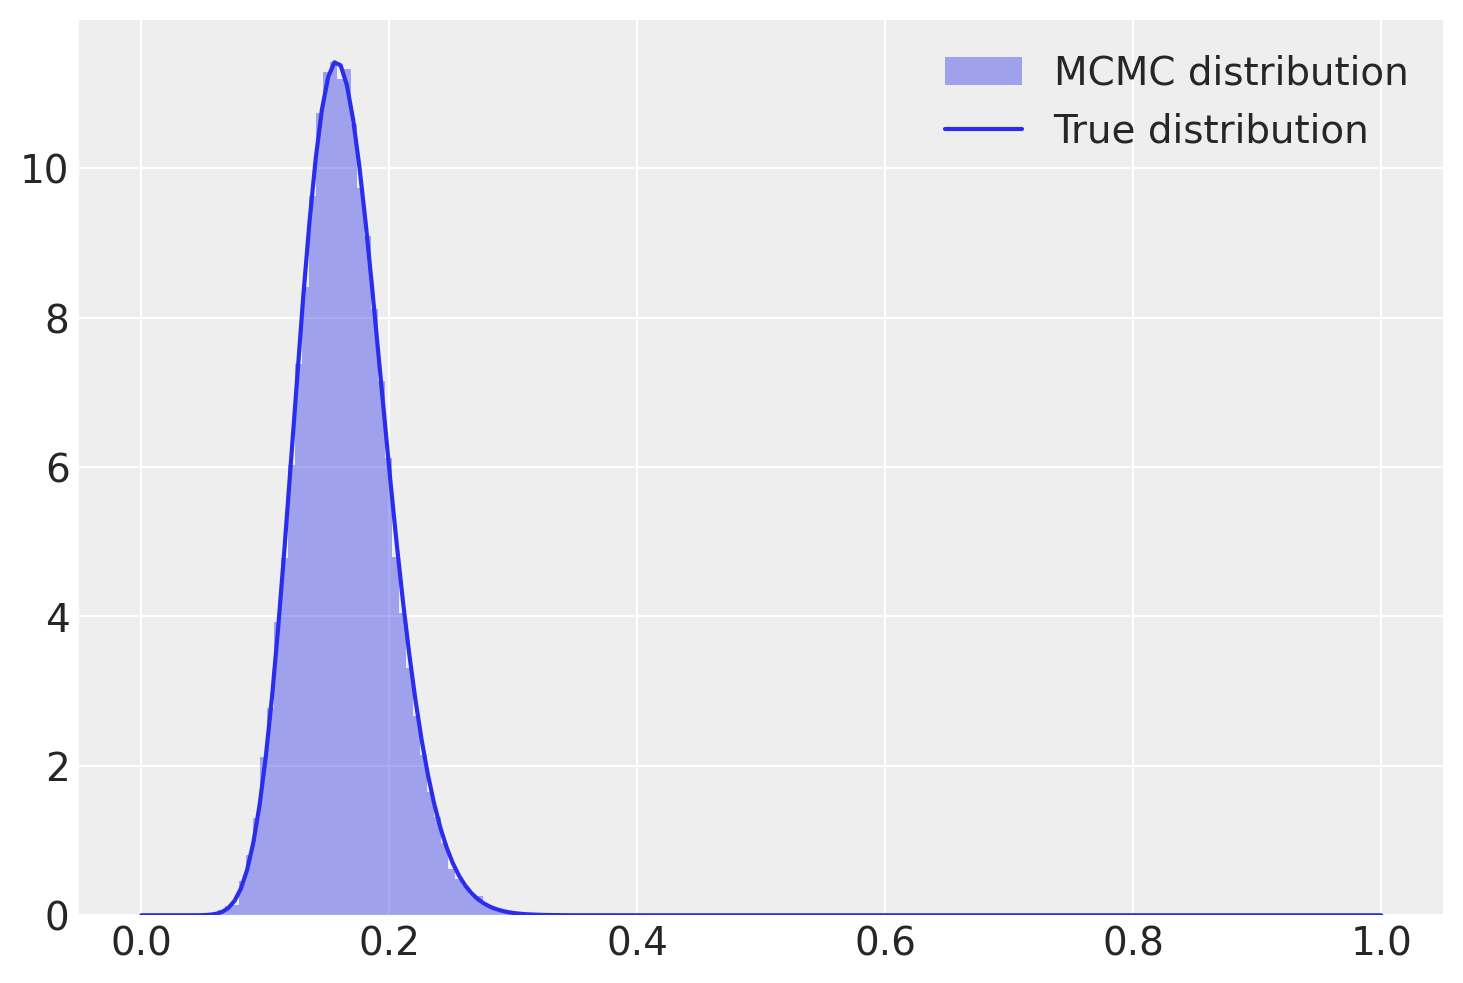

In [20]:
plt.hist(samps, bins=80, alpha=0.4, label="MCMC distribution", density=True)
x = np.linspace(0, 1, 200)
plt.plot(x, stats.beta.pdf(x, 18, 92), "C0", label="True distribution")
plt.legend()
plt.show()

In [21]:
# Proposal distribution
def gaussprop(xprev, sigma=0.1):
    return xprev + stats.norm.rvs(scale=sigma)

In [22]:
samps = metropolis_v1(lambda x: stats.beta.pdf(x, 18, 92), gaussprop, n_samples, init_state)
print(samps[0:20])

[0.20090969 0.13346877 0.13346877 0.13346877 0.13346877 0.13346877
 0.13346877 0.15164492 0.15164492 0.19828971 0.19828971 0.16806675
 0.16806675 0.16806675 0.16806675 0.16806675 0.16806675 0.22020973
 0.14820446 0.13045723]


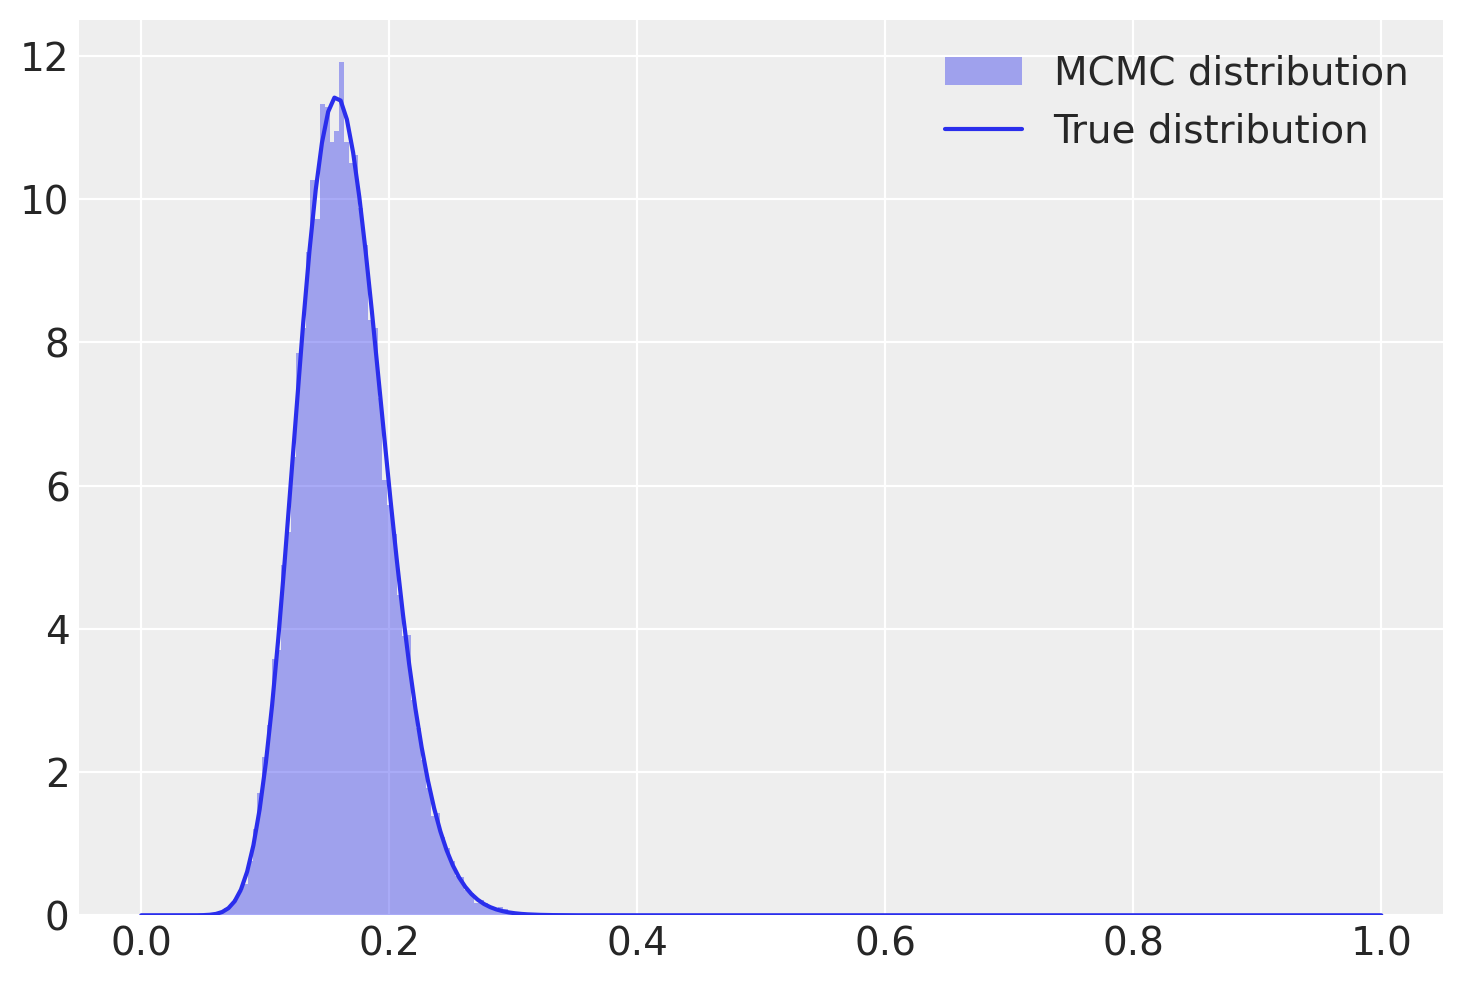

In [23]:
plt.hist(samps, bins=80, alpha=0.4, label="MCMC distribution", density=True)
x = np.linspace(0, 1, 200)
plt.plot(x, stats.beta.pdf(x, 18, 92), "C0", label="True distribution")
plt.legend()
plt.show()

In [24]:
def prior(p):
    alpha = 4
    beta = 6
    return stats.beta.pdf(p, alpha, beta)

In [25]:
def likelihood(p):
    y = 14
    n = 100
    return stats.binom.pmf(y, n, p)

In [26]:
def posterior(p):
    return likelihood(p) * prior(p)

In [27]:
# Definizione della funzione dell'algoritmo di Metropolis.
# nsamp: Numero di campioni da generare.
# xinit: Valore iniziale da cui iniziare il sampling.
def metropolis_v2(nsamp, xinit):
    # Inizializza un array vuoto per conservare i campioni generati.
    samples = np.empty(nsamp)

    # Imposta il primo valore (valore iniziale) da cui partire per la generazione dei campioni.
    x_prev = xinit

    # Inizia un ciclo che si ripeterà per il numero di volte specificato da nsamp (numero di campioni da generare).
    for i in range(nsamp):
        # Genera un nuovo punto (x_star) usando una distribuzione normale (gaussiana).
        # Questo nuovo punto è generato in modo da essere "vicino" al punto precedente (x_prev),
        # con una deviazione standard di 0.1. Questo significa che la maggior parte dei punti
        # sarà entro 0.1 unità da x_prev, ma alcuni potrebbero essere più lontani.
        x_star = np.random.normal(x_prev, 0.1)

        # Verifica che il nuovo punto (x_star) sia un valore plausibile nel contesto del problema.
        # Qui, l'assunzione è che x_star debba essere tra 0 e 1. Se non lo è, il punto è rifiutato.
        if 0 <= x_star <= 1:
            # Calcola il valore della funzione di densità di probabilità posterior per il nuovo punto e il punto precedente.
            # La funzione posterior è definita altrove e rappresenta il prodotto del prior e della likelihood.
            p_star = posterior(x_star)
            p_prev = posterior(x_prev)

            # Calcola il rapporto tra le densità posterior del nuovo punto e del punto precedente.
            # Questo rapporto determina la probabilità di accettare il nuovo punto.
            # Se p_prev è 0, per evitare la divisione per zero, il rapporto è impostato a 1.
            pdfratio = p_star / p_prev if p_prev > 0 else 1

            # Genera un numero casuale tra 0 e 1.
            random_chance = np.random.uniform()

            # Calcola il rapporto tra la densità posteriore del nuovo punto e quella del punto precedente.
            # Se il nuovo punto è migliore o uguale, questo rapporto sarà >= 1.
            # Se il nuovo punto è peggiore, il rapporto sarà un numero fra 0 e 1.
            acceptance_probability = min(1, pdfratio)

            # Se il numero casuale è minore dell'acceptance_probability, accettiamo il nuovo punto.
            # Ciò significa che un punto migliore o uguale viene sempre accettato (perché random_chance sarà sempre < 1),
            # mentre un punto peggiore ha una possibilità basata sul quanto è peggiore.
            if random_chance < acceptance_probability:
                samples[i] = x_star  # Accetta il nuovo punto.
                x_prev = x_star  # Aggiorna il punto precedente con il nuovo punto accettato.
            else:
                samples[i] = x_prev  # Mantiene il punto precedente se il nuovo punto non è accettato.
        else:
            samples[i] = x_prev  # Se x_star non è nel supporto, conserva il punto precedente.

    # Dopo aver generato il numero desiderato di campioni, ritorna l'array dei campioni.
    return samples

In [28]:
n_samples = 100_000
samps = metropolis_v2(n_samples, 0.5)

In [29]:
burnin = int(n_samples * 0.5)
burnin

50000

In [30]:
np.mean(samps[burnin:])

0.16333189691090788

In [31]:
np.std(samps[burnin:])

0.03529394100872187

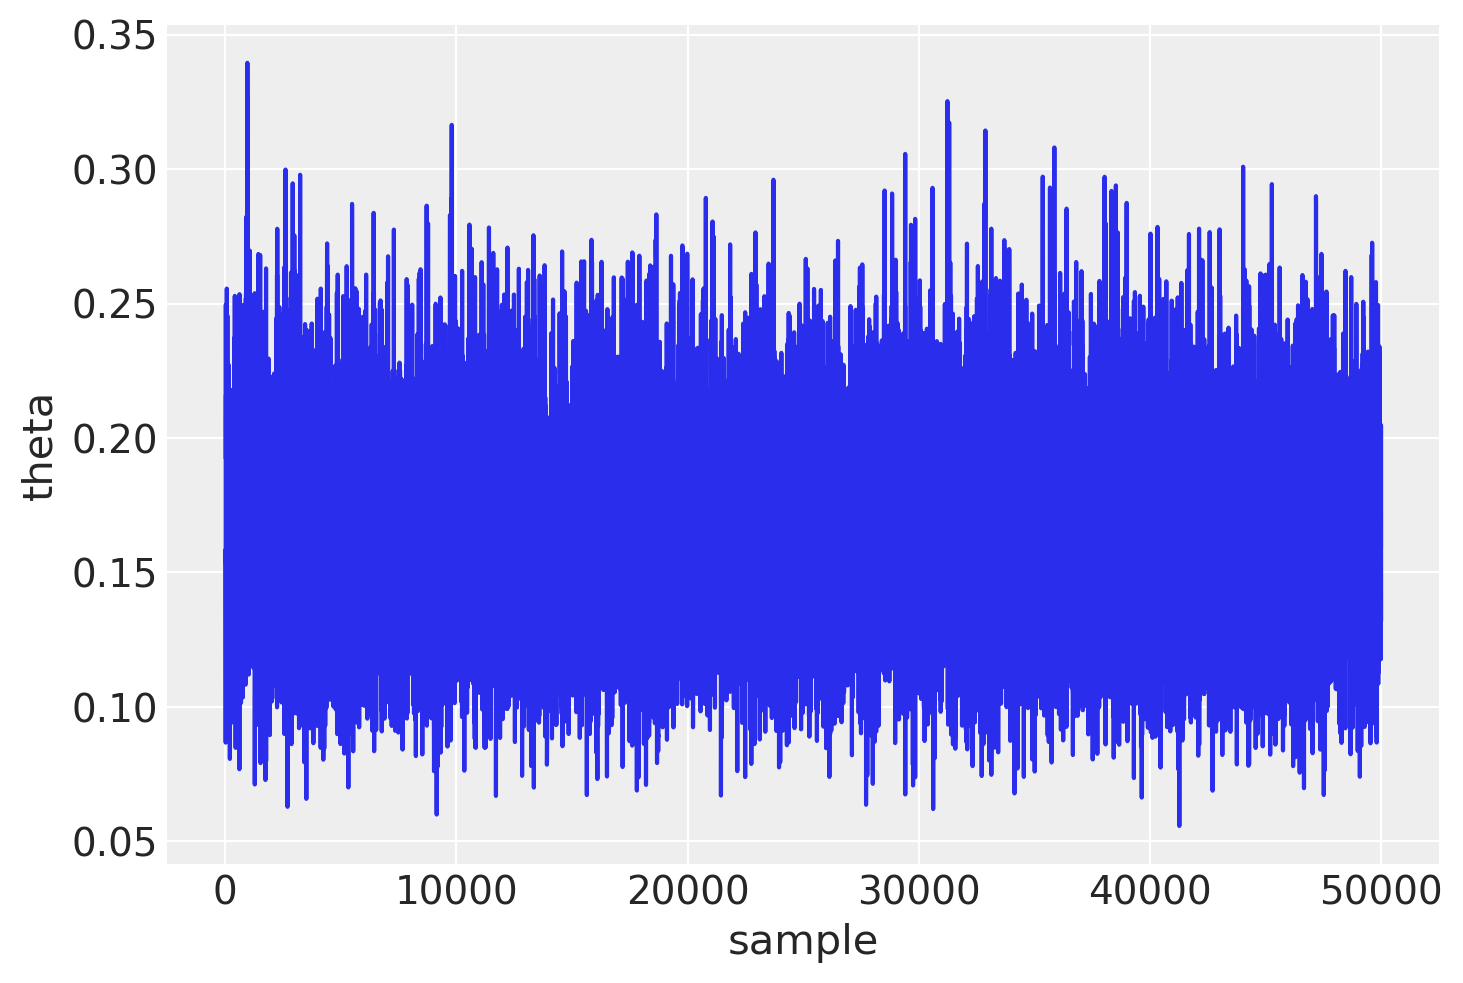

In [32]:
plt.plot(samps[burnin:])
plt.xlabel("sample")
plt.ylabel("theta")
plt.show()

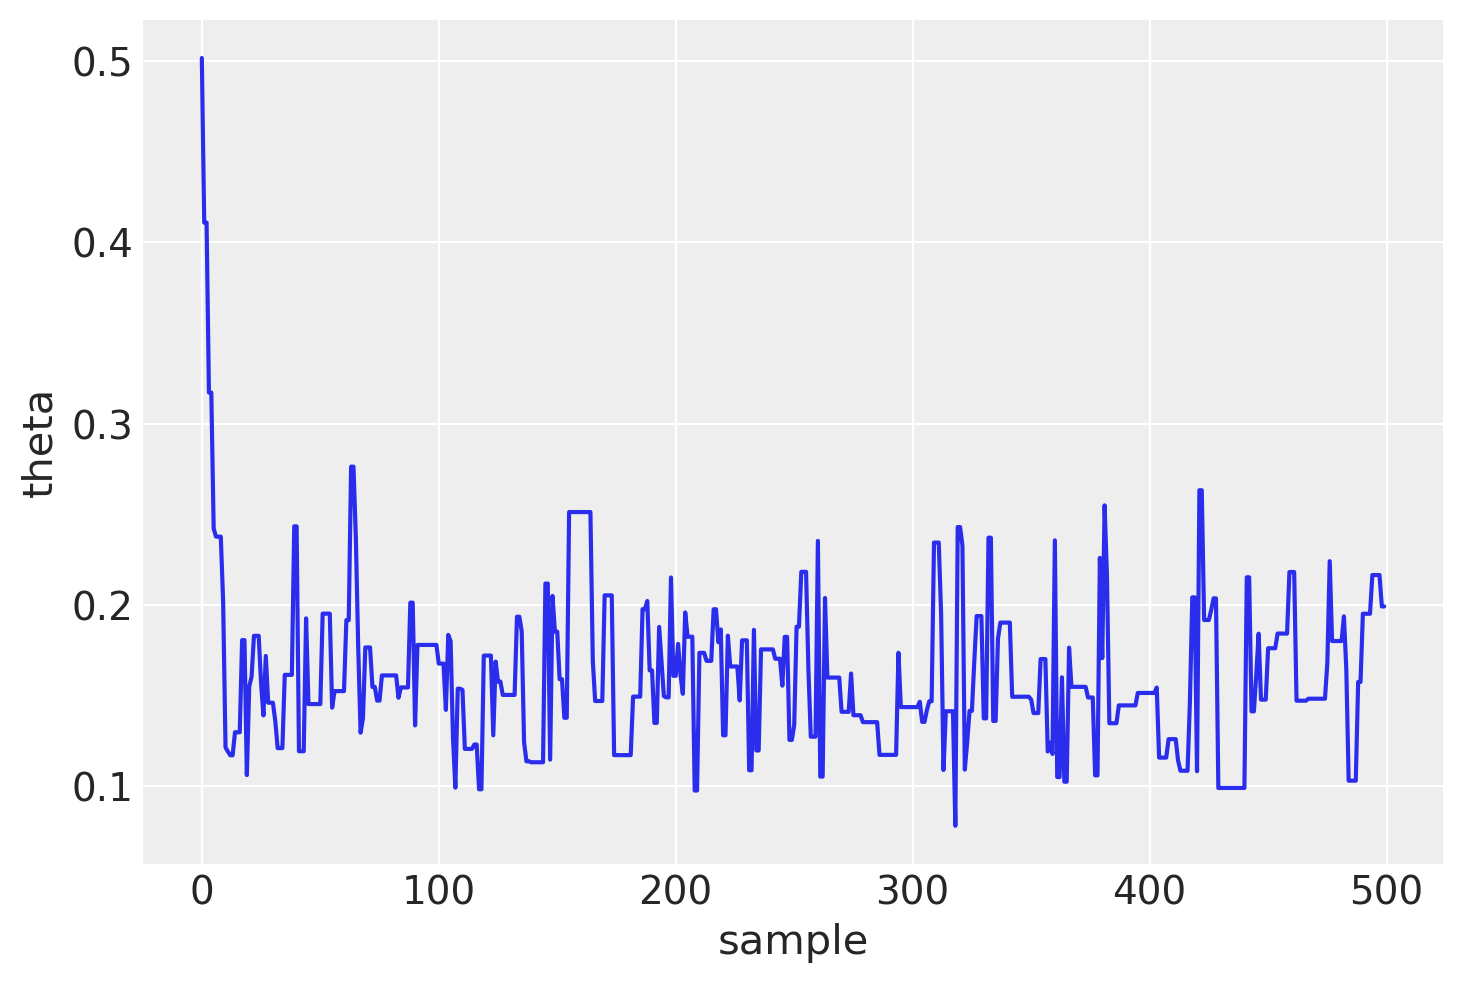

In [33]:
plt.plot(samps[:500])
plt.xlabel("sample")
plt.ylabel("theta")
plt.show()

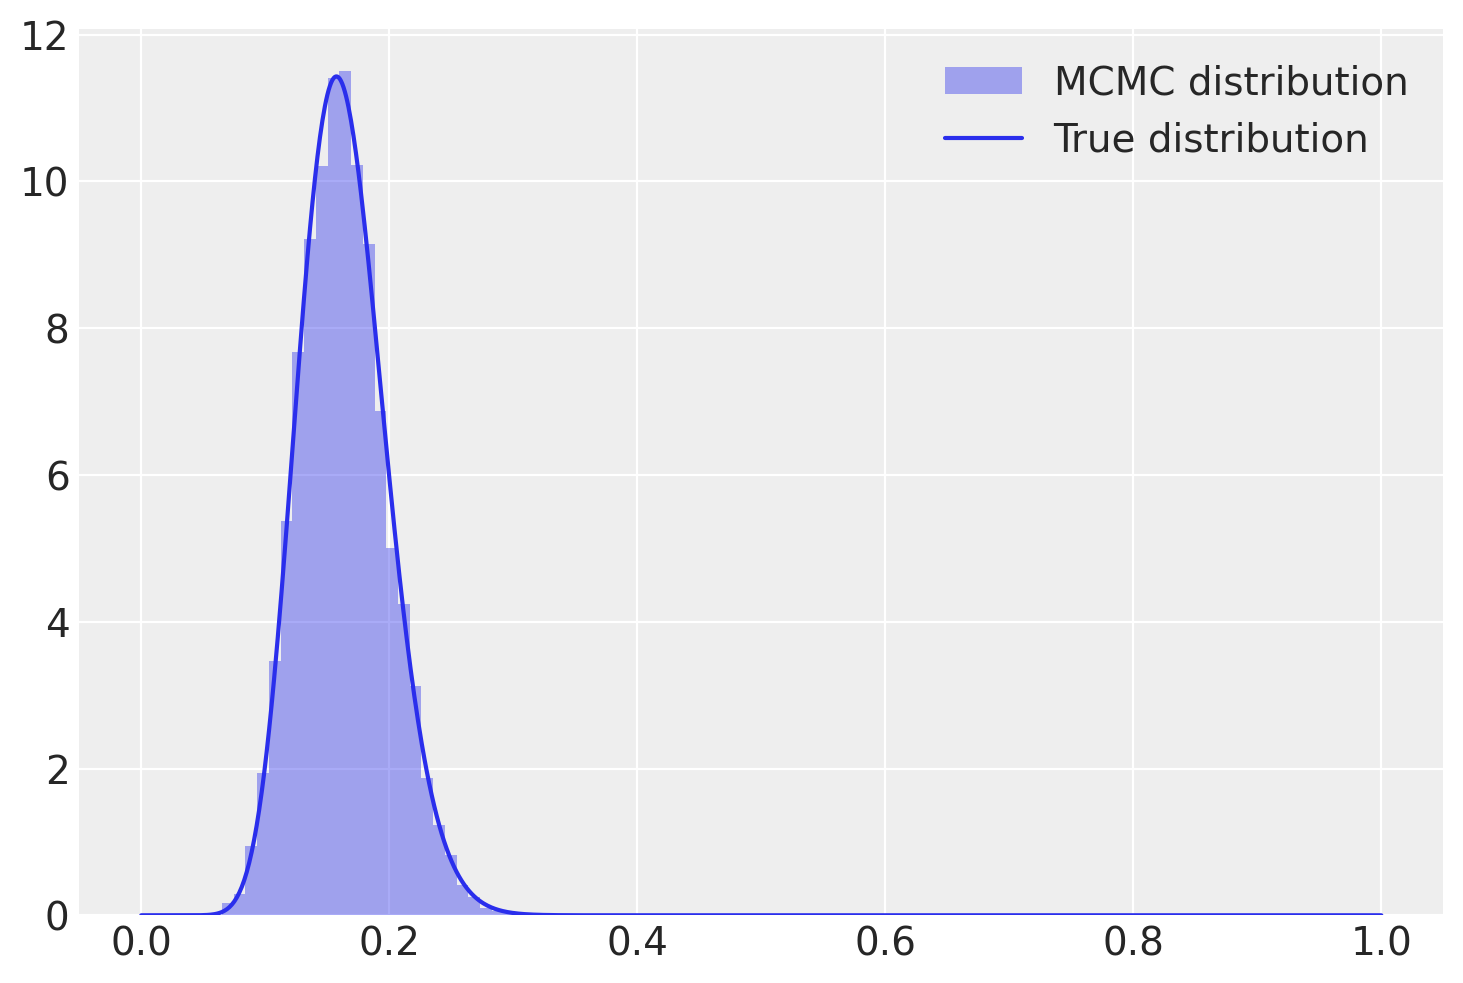

In [34]:
plt.hist(samps[burnin:], bins=30, alpha=0.4, label="MCMC distribution", density=True)
# plot the true function
x = np.linspace(0, 1, 1000)
plt.plot(x, stats.beta.pdf(x, 18, 92), "C0", label="True distribution")
plt.legend()
plt.show()

In [35]:
az.summary(samps[burnin:], kind="stats", hdi_prob=0.94, round_to=2)

,mean,sd,hdi_3%,hdi_97%
x,0.16,0.04,0.1,0.23


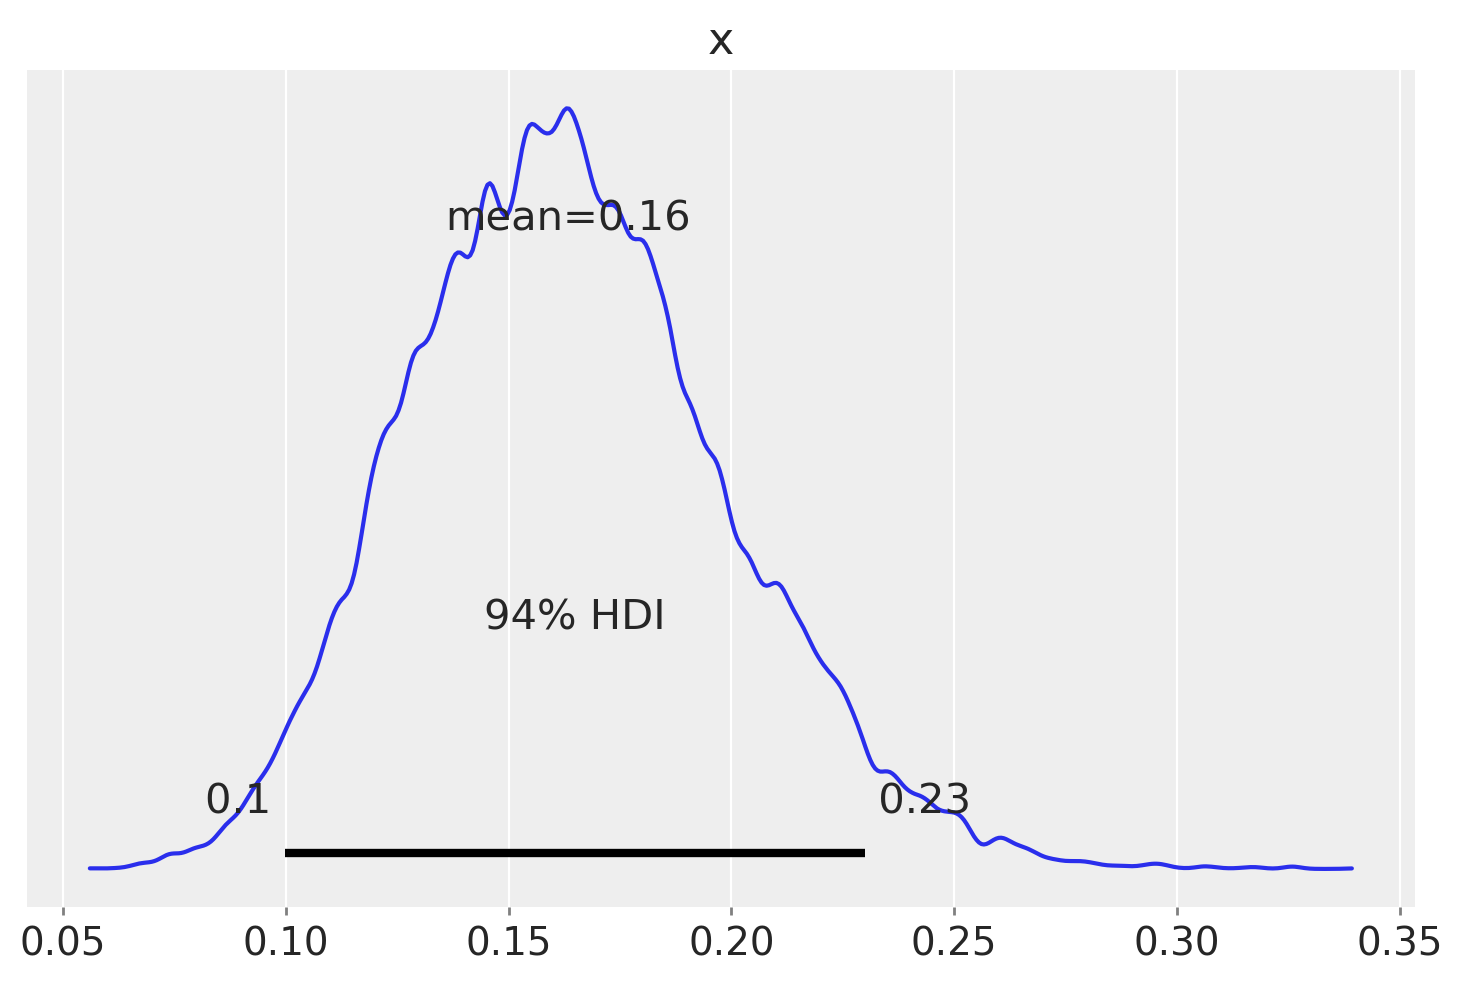

In [36]:
az.plot_posterior(samps[burnin:])
plt.show()

In [37]:
x = pd.array([22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51])
print(x)

<IntegerArray>
[22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51]
Length: 15, dtype: Int64


In [38]:
sm.tsa.acf(x)

array([ 1.        ,  0.83174224,  0.65632458,  0.49105012,  0.27863962,
        0.03102625, -0.16527446, -0.30369928, -0.40095465, -0.45823389,
       -0.45047733, -0.36933174])

In [39]:
sm.tsa.acf(x, nlags=4)

array([1.        , 0.83174224, 0.65632458, 0.49105012, 0.27863962])

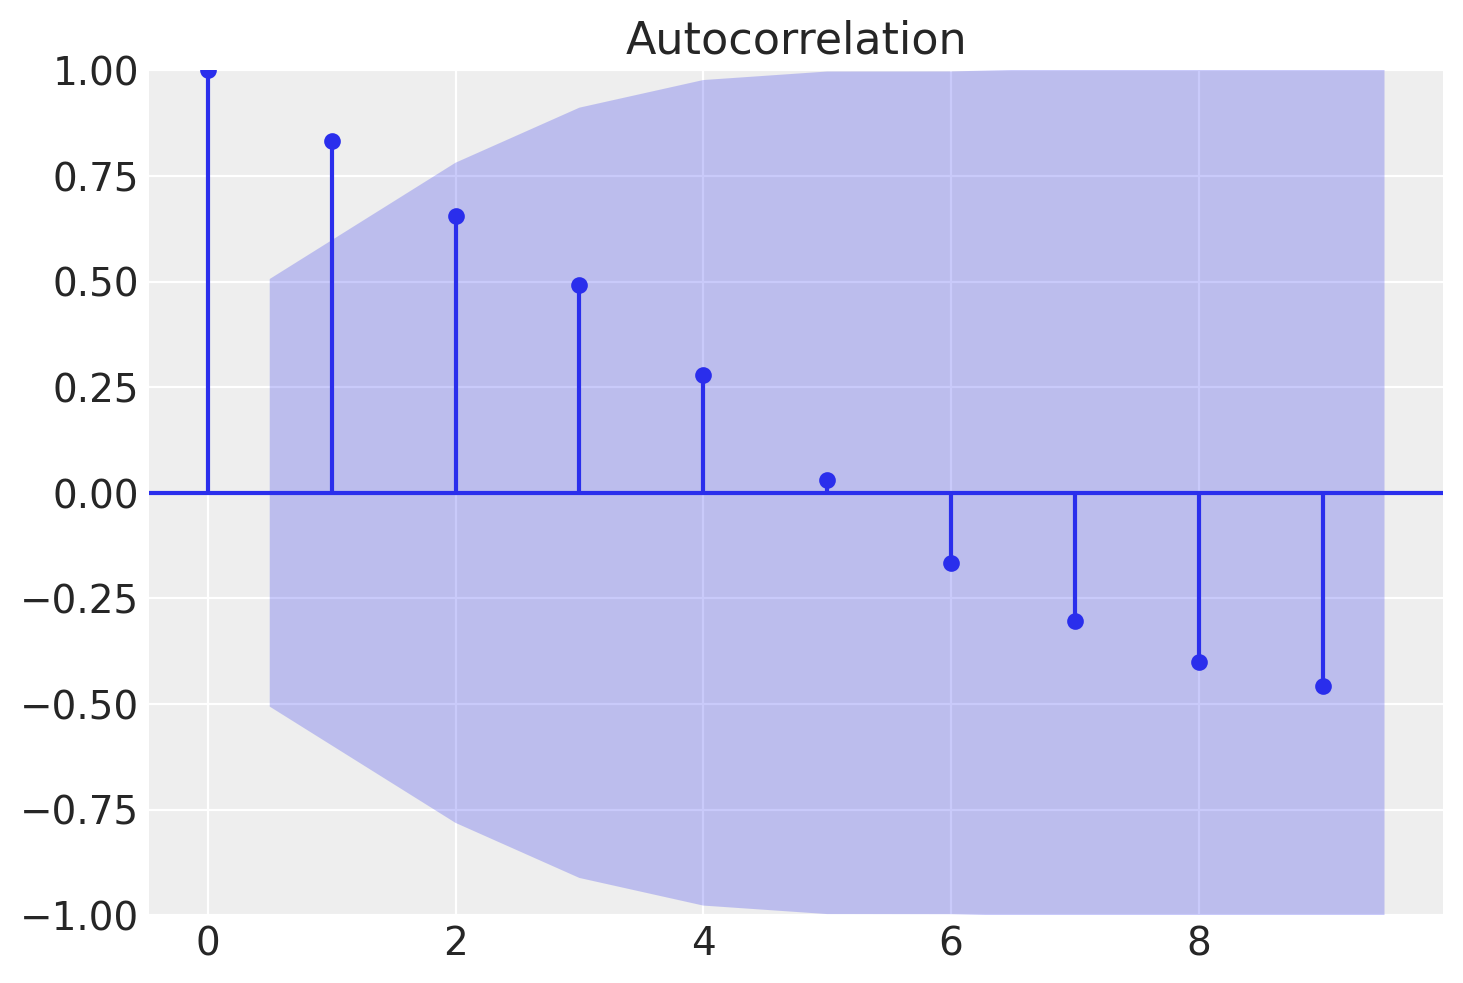

In [40]:
tsaplots.plot_acf(x, lags=9)
plt.show()

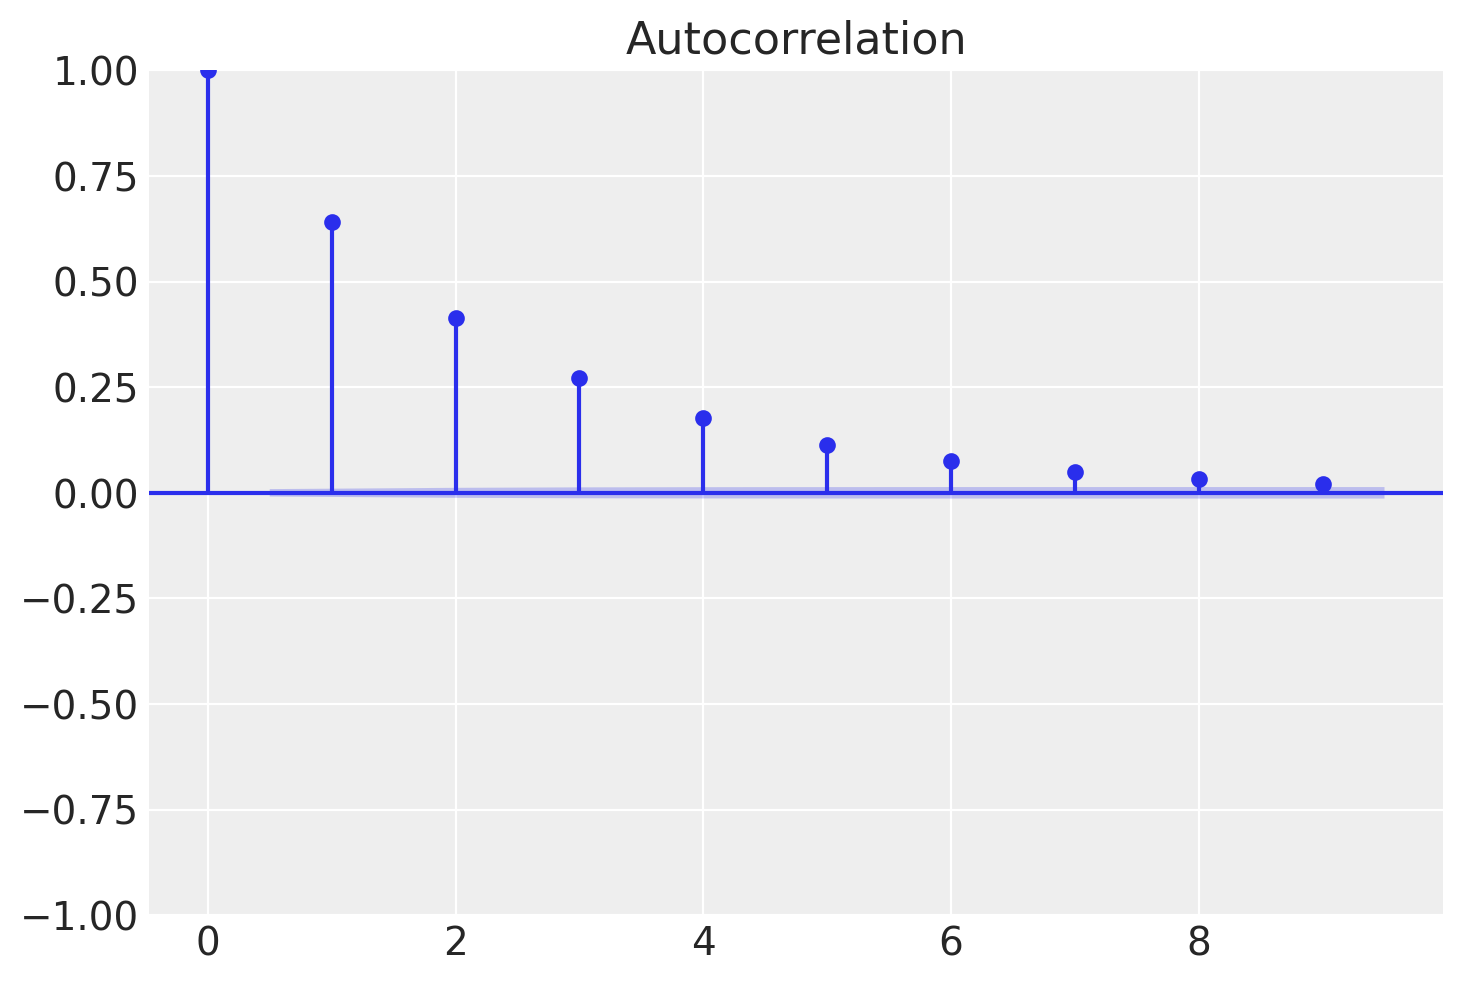

In [41]:
tsaplots.plot_acf(samps[burnin:], lags=9)
plt.show()

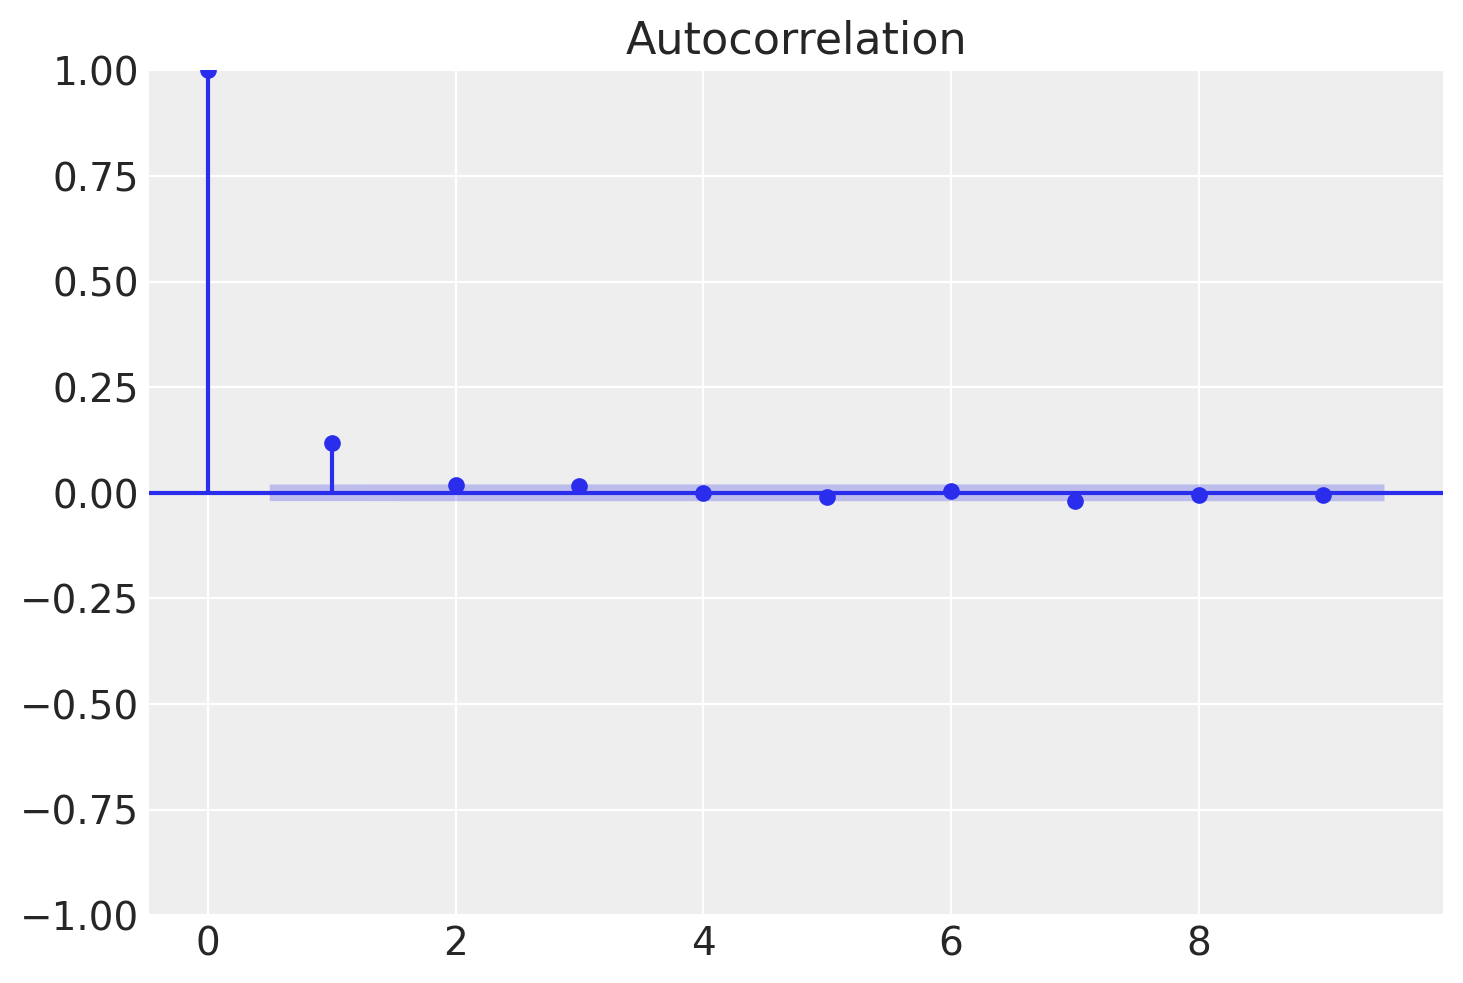

In [42]:
thin = 5
sampsthin = samps[burnin::thin]
tsaplots.plot_acf(sampsthin, lags=9)
plt.show()

In [43]:
def prior(mu):
    return stats.norm.pdf(mu, 30, 5)

In [44]:
def likelihood(mu, data):
    std_data = np.std(data)  # Calcola la deviazione standard dei dati
    return np.prod(stats.norm.pdf(data, mu, std_data))

In [45]:
def posterior(mu, data):
    return likelihood(mu, data) * prior(mu)

In [46]:
# Algoritmo di Metropolis per il caso normale-normale
def metropolis_for_normal(nsamp, xinit, data):
    samples = np.empty(nsamp)
    x_prev = xinit

    for i in range(nsamp):
        x_star = np.random.normal(x_prev, 0.5)  # Genera un nuovo punto dalla proposta

        # Calcola il rapporto di accettazione e accetta il nuovo punto con una certa probabilità
        if posterior(x_star, data) / posterior(x_prev, data) > np.random.uniform():
            x_prev = x_star

        samples[i] = x_prev

    return samples

In [47]:
y = np.array([
    26.0, 35.0, 30, 25, 44, 30, 33, 43, 22, 43, 24, 19, 39, 31, 25, 28, 35, 30, 26, 31,
    41, 36, 26, 35, 33, 28, 27, 34, 27, 22,
])

In [48]:
samples = metropolis_for_normal(100_000, np.mean(y), y)
samples.shape

(100000,)

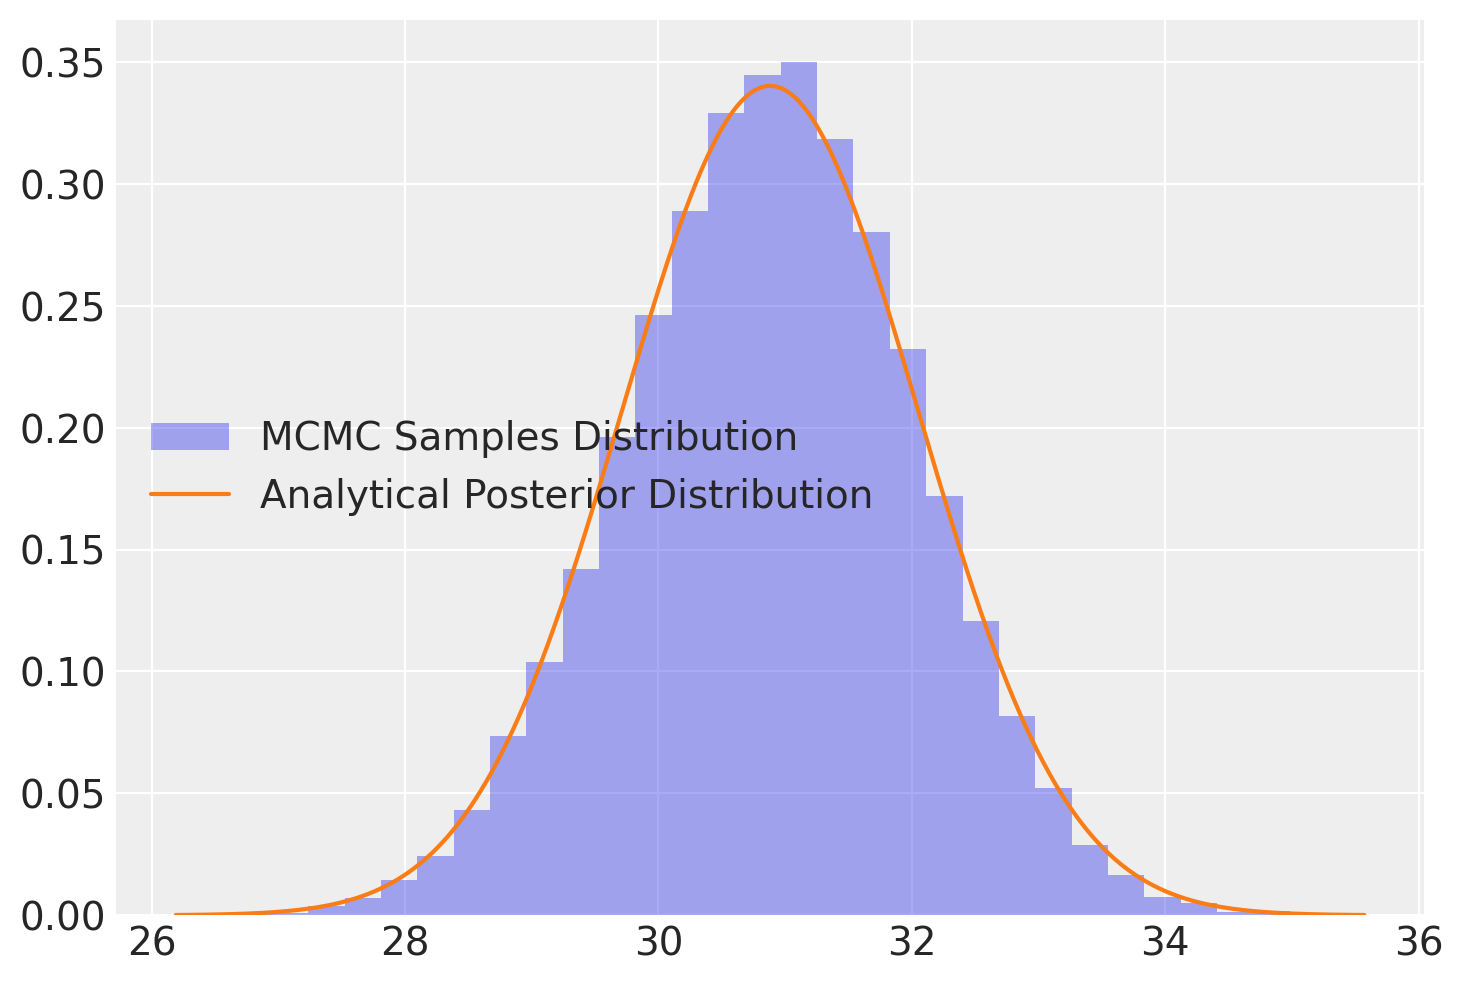

In [49]:
# Parametri del prior
mu_prior = 30
std_prior = 5
var_prior = std_prior ** 2

# Dati osservati
n = len(y)
sum_y = np.sum(y)
var_data = np.var(y, ddof=1)  # ddof=1 for sample variance

# Calcolo dei parametri posterior
mu_post = (mu_prior / var_prior + sum_y / var_data) / (1 / var_prior + n / var_data)
var_post = 1 / (1 / var_prior + n / var_data)
std_post = np.sqrt(var_post)

# Generazione dei punti x per il grafico
x = np.linspace(mu_post - 4 * std_post, mu_post + 4 * std_post, 1000)

# Istogramma dei campioni dal posterior
plt.hist(samples[burnin:], bins=30, alpha=0.4, density=True, label="MCMC Samples Distribution")

# Curva della distribuzione posteriore analitica
plt.plot(x, stats.norm.pdf(x, mu_post, std_post), "C1", label="Analytical Posterior Distribution")

plt.legend()
plt.show()

In [50]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

statsmodels: 0.14.2
pandas     : 2.2.2
arviz      : 0.18.0
scipy      : 1.13.1
matplotlib : 3.8.4
numpy      : 1.26.4

Watermark: 2.4.3

